In [16]:
import pycuda.driver as cuda
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
import numpy as np
import cv2
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import time

In [17]:
input_image = cv2.imread('/mnt/d/CUDA/day7/image.jpg')
height, width, _  = input_image.shape

rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

input_array = rgb.flatten()

In [18]:
img_in = cuda.mem_alloc(input_array.nbytes)
img_out = cuda.mem_alloc(input_array.nbytes)

cuda.memcpy_htod(img_in, input_array)

In [19]:
filepath = "/mnt/d/CUDA/day7/gaussianBlur.ptx"

module = cuda.module_from_file(filepath)
blur = module.get_function('imageBlur')

In [20]:
blur_radius = 15 #31x31 filter size
sigma = 5        #variance

n_threads = (32, 32, 1)
block_x = (n_threads[0] + width - 1) // n_threads[0]
block_y = (n_threads[1] + height - 1) // n_threads[1]
grid = (block_x, block_y, 1)

In [21]:
blur(img_in, img_out, np.int32(width), np.int32(height), np.int32(blur_radius), np.int32(sigma), block=n_threads, grid=grid)

output_array = np.empty_like(input_array)
cuda.memcpy_dtoh(output_array, img_out)

result_rgb = output_array.reshape((height, width, 3))
result_bgr = cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR)

In [22]:
size = (2 * blur_radius + 1, 2 * blur_radius + 1)

opencv_blurred = cv2.GaussianBlur(input_image, size, sigmaX=sigma)

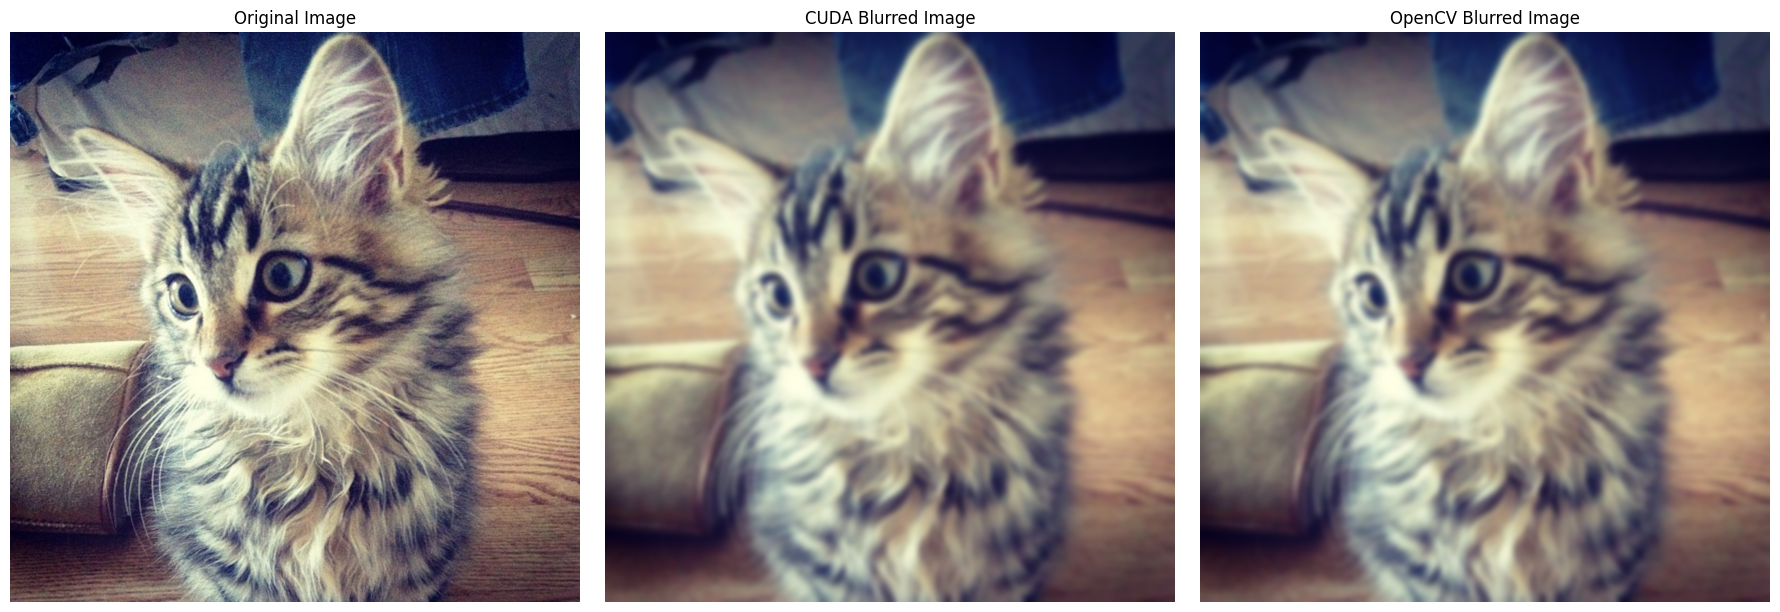

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(rgb)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(result_rgb)
ax[1].set_title("CUDA Blurred Image")
ax[1].axis("off")

opencv_blurred_rgb = cv2.cvtColor(opencv_blurred, cv2.COLOR_BGR2RGB)
ax[2].imshow(opencv_blurred_rgb)
ax[2].set_title("OpenCV Blurred Image")
ax[2].axis("off")

plt.tight_layout()
plt.show()